# Collaborative Filtering based Recommender System

<figure style="display: block; margin-left: auto; margin-right: auto; width: 90%; text-align: center;">
  <img src="figures/Recommender-systems-1024x628.jpg" alt="Recommender Systems.">
    <figcaption>Image source: <a href="http://webindiasolutions.biz/webindiasolutions.co.in/predmac/blog-recommender-systems/">http://webindiasolutions.biz/webindiasolutions.co.in/predmac/blog-recommender-systems/</a></figcaption>
</figure>

Recommender systems are one of the most successful and widespread application of machine learning technologies in industry. The ability to suggest products with most appealing factor to each consumer type of your clients base is trivial not only to keep your clients engaged, but to atract new costumers. The business model and success of big companys like Netflix, Amazon, Steam, Spotify, YouTube and many others, revolves around the potency of their *Recommender Systems*.

A recommender system deals with the task of predict the degree of similarity between items (movies, songs, clothing, shoes, etc) or users in a database. Based on these similarities the system can provide personalized *recommendations* of items for users.

Generally speaking, recommender systems can be classified into 3 types:

* **Collaborative Filtering based:** These systems predict the rating or preference that a user would give an item based on past user ratings or preferences. No item metadata is required, in contrast to its content-based counterparts.

* **Content-based Filtering:** These systems predict the item rating or user preference based on item metadata (genre, director, description, actors, color, etc) and user preferences and history. These systems dependes highly on item metadata.

* **Hybrid systems:** These systems try to leverage the best of both worlds and constitutes a wide range of state-of-art techniques in industry. These are complex systems, usually made of multiple smaller subsystems.

Those system types have their own pros and cons. In this post we'll implement a simple Collaborative Filtering based system.

# Collaborative Filtering

As said before, Collabortative Filtering (CF) is a type of recommendation technique that uses similarities between users (or items) to infer the possible level of interest of a user to a item unrated by him. These similarities are computed using sonenly existing user ratings for items. Thus specific item description metadata is not needed.

There are two general CF approaches:

* **User-based**, which exploits similarities between **users**. A rating prediction of an user to an item is computed using the item ratings given by similar users.
* **Item-based**, which exploits similarities between **items**. A rating prediction of an user to an item is computed using ratings of similar items.
<figure style="display: block; margin-left: auto; margin-right: auto; width: 90%; text-align: center;">
  <img src="figures/recommenders_systems.png" alt="CF approaches.">
    <figcaption>CF approaches. Image source: <a href="https://predictivehacks.com/item-based-collaborative-filtering-in-python/">https://predictivehacks.com/item-based-collaborative-filtering-in-python/</a></figcaption>
</figure>

In both cases, the first step to build the system is to compute an **interactions matrix**, where each row contains the ratings given by a user to all items in database, and each columns contains the ratings given by all users to an specific item.

Figure below illustrate an example interactions matrix. User ratings are in range 1 to 5. A rating 0 means that this specific item was not rated by this specific user.

<figure style="display: block; margin-left: auto; margin-right: auto; width: 90%; text-align: center;">
  <img src="figures/sample_iter_mat.png" alt="Example interaction matrix">
  <figcaption>Example interaction matrix</figcaption>
</figure>

The **interactions matrix** is, naturally, an *sparse matrix*: in practical scenarios, the majority of the users may not have rated the majority of the items. This may lead to adoption of specific algorithms to deal with sparse data.

Two main algorithm types are used to implement recommender systems (either item-based or user-based):

* **Memory based**, in which statistical techniques are applied to the entire dataset to calculate the rating predictions.

* **Model based**, which involve steps to reduce or compress the large, but possibly sparse, interactions matrix.

In this post, we'll use a *memory based* strategy, which is simpler to explain and easier to understand. In a future post we'll cover the implementation of a *model based* approach.

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

from skopt import gp_minimize
from skopt.space import Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

import matplotlib.pyplot as plt

import re

# The MovieLens 100K Dataset

There are a number of datasets available for recommendations systems research. Amongst them, the [MovieLens](https://grouplens.org/datasets/movielens) dataset is probably one of the more popular ones. MovieLens is a non-commercial web-based movie recommender system, created in 1997 and run by the GroupLens Research Project, at University of Minnesota. It's data has been critical for several research studies including personalized recommendation and social psychology.

There are several versions of the dataset available. We'll use the well-known [MovieLens 100k](https://grouplens.org/datasets/movielens/100k/), which consists of 100,000 ratings form 943 users on 1682 movies. Some simple demographic information such as age, gender, genres for the users and items are also available, but we'll not use them.

In [2]:
# # Download the dataset
# !wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
# # Unzip it
# !unzip ml-100k.zip
# # Get rid of the .zip file
# !rm ml-100k.zip

The dataset folder contains several files, but we need only two of them:

* **u.data**: The full dataset with 100,000 user ratings. Each user has rated at least 20 movies.
* **u.item**: Contains informations about the movies, but we will use only movies ids and titles. This data is not required for the understanding of the CF technique, but we will use it for a more friendly feedback of our system.

Let's begin by loading the ratings dataframe.

In [3]:
ratings = pd.read_csv(
    "ml-100k/u.data",
    sep="\t", # this is a tab separated data
    names=["user_id", "movie_id", "rating", "timestamp"], # the columns names
    usecols=["user_id", "movie_id", "rating"], # we do not need the timestamp column
    low_memory=False
)
ratings

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


Each entry consists in a *user_id*, *movie_id* and a movie *rating* in range of 1 to 5.

The next information we need is the number of movies and users in the dataset. Although we already know this from the dataset information, for didactic purposes we'll get them from the data itself.

In [4]:
n_users = len(ratings.user_id.unique())
n_movies = len(ratings.movie_id.unique())

print(f"Number of users: {n_users} -- Number of movies: {n_movies}")

Number of users: 943 -- Number of movies: 1682


## Train/test split

Now we'll create the train and test sets that we will use to evaluate the performance of our system. 20% of each user ratings will be used for testing, and the remaining that will be used for training.

In [5]:
test_perc = 0.2

# Initialize the train and test dataframes.
train_set, test_set = pd.DataFrame(), pd.DataFrame()

# Check each user.
for user_id in ratings.user_id.unique():
    user_df = ratings[ratings.user_id == user_id].sample(
        frac=1,
        random_state=42
    ) # select only samples of the actual user and shuffle the resulting dataframe
    
    n_entries = len(user_df)
    n_test = int(round(test_perc * n_entries))
    
    test_set = pd.concat((test_set, user_df.tail(n_test)))
    train_set = pd.concat((train_set, user_df.head(n_entries - n_test)))

train_set = train_set.sample(frac=1).reset_index(drop=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)

train_set.shape, test_set.shape

((80000, 3), (20000, 3))

We also need a function to compute the *interactions matrix* of a given ratings dataframe.

In [6]:
def build_interactions_matrix(r_mat, n_users, n_items):
    iter_m = np.zeros((n_users, n_items))
    
    for _, user_id, movie_id, rating in r_mat.itertuples():
        iter_m[user_id-1, movie_id-1] = rating
    
    return iter_m

In [7]:
iter_m = build_interactions_matrix(ratings, n_users, n_movies)
iter_m.shape

(943, 1682)

## Memory based approach

In this post we'll build our system using the **memory based** approach, in which similarities between users/items are computed using the rating data itself. Therefore, the *i*-th row of an interactions matrix is considered as the **feature vector** of user *i*, while the *j*-th column of an interaction matrix is considered as the **feature vector** of item *j*.

<figure style="display: block; margin-left: auto; margin-right: auto; width: 90%; text-align: center;">
  <img src="figures/memory_based.png" alt="Feature vectors in CF memory-based approach">
  <figcaption>Feature vectors in CF memory-based approach</figcaption>
</figure>

The similarity between two users is represented by some **distance measurement** between their feature vectors. Multiple measures, such as Pearson correlation and vector cosine are used for this. For example, the similarity between users $u$ and $u'$ can be computed using vector cosine as:
$$
sim(u, u') = cos(\textbf{r}_u, \textbf{r}_{u'}) = 
\frac{\textbf{r}_u \textbf{.} \textbf{r}_{u'}}{|\textbf{r}_u||\textbf{r}_{u'}|} =
\frac{\sum_i r_{ui}r_{u'i}}{\sqrt{\sum_i r_{ui}^2}\sqrt{\sum_i r_{u'i}^2}}
$$
where $\textbf{r}_u$ and $\textbf{r}_{u'}$ are the feature vectors of users $u$ and $u'$, respectively, and $r_{ui}$ is a rating value given by user $u$ to item $i$. The same procedure is applied when computing the similarity between items $i$ and $i'$.

In [8]:
def build_similarity_matrix(interactions_matrix, kind="user", eps=1e-9):
    # takes rows as user features
    if kind == "user":
        similarity_matrix = interactions_matrix.dot(interactions_matrix.T)
    # takes columns as item features
    elif kind == "item":
        similarity_matrix = interactions_matrix.T.dot(interactions_matrix)
    norms = np.sqrt(similarity_matrix.diagonal()) + eps
    return similarity_matrix / (norms[np.newaxis, :] * norms[:, np.newaxis])

In [9]:
u_sim = build_similarity_matrix(iter_m, kind="user")
i_sim = build_similarity_matrix(iter_m, kind="item")

print(f"User similarity matrix shape: {u_sim.shape}\nUser similarity matrix sample:\n{u_sim[:4, :4]}")
print("-" * 97)
print(f"Item similarity matrix shape: {i_sim.shape}\nItem similarity matrix sample:\n{i_sim[:4, :4]}")

User similarity matrix shape: (943, 943)
User similarity matrix sample:
[[1.         0.16693098 0.04745954 0.06435782]
 [0.16693098 1.         0.11059132 0.17812119]
 [0.04745954 0.11059132 1.         0.34415072]
 [0.06435782 0.17812119 0.34415072 1.        ]]
-------------------------------------------------------------------------------------------------
Item similarity matrix shape: (1682, 1682)
Item similarity matrix sample:
[[1.         0.40238218 0.33024479 0.45493792]
 [0.40238218 1.         0.27306918 0.50257077]
 [0.33024479 0.27306918 1.         0.32486639]
 [0.45493792 0.50257077 0.32486639 1.        ]]


The similarity matrix is a symmetric matrix with values in range 0 to 1. The diagonal elements contains the auto-similarities of all users/items, so all elements are equal to 1.

# Making Predictions

Now we are able to make predictions. Depending on which approach we have chosen for our system, we have two different objectives:

1. If we choose the user-based approach, we'll infer a missing rating $r_{ui}$ of an user $u$ to an item $i$ by taking the normalized weighted sum of **all ratings of other users to this item**.

$$
r_{ui} = \frac{\sum_{u'} sim(u, u')r_{u'i}}{\sum_{u'} |sim(u, u')|}
$$

2. If we choose the item-based approach instead, we'll infer a missing rating $r_{ui}$ of an user $u$ to an item $i$ by taking the normalized weighted sum of **all other ratings of this user to the other items**.

$$
r_{ui} = \frac{\sum_{i'} sim(i, i')r_{ui'}}{\sum_{i'} |sim(i, i')|}
$$

## The Recommender class

Let's build a *Recommender* class, that will do all the heavy lifting of compute/store the similarity matrices and make rating predictions for us.

In [10]:
class Recommender:
    def __init__(
        self,
        n_users,
        n_items,
        r_mat,
        kind="user",
        eps=1e-9,
    ):
        self.n_users = n_users
        self.n_items = n_items
        self.kind = kind
        self.eps = eps
        self.iter_m = build_interactions_matrix(r_mat, self.n_users, self.n_items)
        self.sim_m = build_similarity_matrix(self.iter_m, kind=self.kind)
        self.predictions = self._predict_all()
    
    def _predict_all(self):
        if self.kind == "user":
            predictions = \
                self.sim_m.dot(self.iter_m) / np.abs(self.sim_m + self.eps).sum(axis=0)[:, np.newaxis]
        elif self.kind == "item":
            predictions = \
                self.iter_m.dot(self.sim_m) / np.abs(self.sim_m + self.eps).sum(axis=0)[np.newaxis, :]
        return predictions

In [11]:
print("User-based predictions sample:")
print(Recommender(n_users, n_movies, train_set, kind="user").predictions[:4, :4])
print("-" * 97)
print("item-based predictions sample:")
print(Recommender(n_users, n_movies, train_set, kind="item").predictions[:4, :4])

User-based predictions sample:
[[1.83706987 0.6257035  0.33869847 1.00876026]
 [1.5422442  0.27024912 0.23318095 0.48654518]
 [0.9610046  0.22919461 0.16521262 0.38923742]
 [1.2288292  0.27348381 0.20238746 0.47424947]]
-------------------------------------------------------------------------------------------------
item-based predictions sample:
[[0.97004593 0.88005233 0.88561114 0.94116817]
 [0.23553281 0.1252388  0.17800975 0.15055959]
 [0.08729475 0.0632449  0.0812641  0.06648524]
 [0.07542813 0.05258989 0.06783286 0.05653723]]


## Model evaluation

Now it's time to assess the predictor performance. For this we'll use *Mean Squared Error* (MSE) metric.

In [12]:
def build_predictions_df(preds_m, dataframe):
    preds_v = []
    for row_id, user_id, movie_id, _ in dataframe.itertuples():
        preds_v.append(preds_m[user_id-1, movie_id-1])
    preds_df = pd.DataFrame(data={"user_id": dataframe.user_id, "movie_id": dataframe.movie_id, "rating": preds_v})
    return preds_df

def get_mse(estimator, train_set, test_set):
    train_preds = build_predictions_df(estimator.predictions, train_set)
    test_preds = build_predictions_df(estimator.predictions, test_set)
    
    train_mse = mean_squared_error(train_set.rating, train_preds.rating)
    test_mse = mean_squared_error(test_set.rating, test_preds.rating)
    
    return train_mse, test_mse

In [13]:
train_mse, test_mse = get_mse(
    Recommender(n_users, n_movies, train_set, kind="user"),
    train_set,
    test_set
)

print(f"User-based train MSE: {train_mse} -- User-based test MSE: {test_mse}")
print("-" * 97)

train_mse, test_mse = get_mse(
    Recommender(n_users, n_movies, train_set, kind="item"),
    train_set,
    test_set
)

print(f"Item-based train MSE: {train_mse} -- Item-based test MSE: {test_mse}")

User-based train MSE: 8.70310424270717 -- User-based test MSE: 8.914272669040075
-------------------------------------------------------------------------------------------------
Item-based train MSE: 9.436480326757003 -- Item-based test MSE: 9.72671269086236


## K-nearest neighbors

At this point the rating predictions are computed using the ratings of either all users or all items. This means that even the users/items with low similarity scores will be acounted for the prediction computation. A better approach is to take an smaller subset of the most similar users/items to make a prediction. This technique is usually refered as *k-nearest neighbors*, or *KNN* algorithm.

We'll adapt our Estimator class to use only the most similar users/items to make an prediction.

In [14]:
class Recommender:
    def __init__(
        self,
        n_users,
        n_items,
        r_mat,
        k=40, # the number of neighbors to use when computing the similarity score
        kind="user",
        eps=1e-9
    ):
        self.n_users = n_users
        self.n_items = n_items
        self.kind = kind
        self.eps = eps
        self.iter_m = build_interactions_matrix(r_mat, self.n_users, self.n_items)
        self.sim_m = build_similarity_matrix(self.iter_m, kind=self.kind)
        self.k = k
        self.predictions = self._predict_all()
    
    def _predict_all(self):
        pred = np.empty_like(self.iter_m)
        if self.kind == "user":
            # An user has the higher similarity score with itself,
            # so we skip the first element.
            sorted_ids = np.argsort(-self.sim_m)[:, 1:self.k+1]
            for user_id, k_users in enumerate(sorted_ids):
                pred[user_id, :] = self.sim_m[user_id, k_users].dot(self.iter_m[k_users, :])
                pred[user_id, :] /= np.abs(self.sim_m[user_id, k_users] + self.eps).sum()
        elif self.kind == "item":
            # An item has the higher similarity score with itself,
            # so we skip the first element.
            sorted_ids = np.argsort(-self.sim_m)[:, 1:self.k+1]
            for item_id, k_items in enumerate(sorted_ids):
                pred[:, item_id] = self.sim_m[item_id, k_items].dot(self.iter_m[:, k_items].T)
                pred[:, item_id] /= np.abs(self.sim_m[item_id, k_items] + self.eps).sum()
        return pred

In [15]:
train_mse, test_mse = get_mse(
    Recommender(n_users, n_movies, train_set, kind="user"),
    train_set,
    test_set
)

print(f"User-based train MSE: {train_mse} -- User-based test MSE: {test_mse}")
print("-" * 97)

train_mse, test_mse = get_mse(
    Recommender(n_users, n_movies, train_set, kind="item"),
    train_set,
    test_set
)

print(f"Item-based train MSE: {train_mse} -- Item-based test MSE: {test_mse}")

User-based train MSE: 5.490605431419921 -- User-based test MSE: 6.174640689172994
-------------------------------------------------------------------------------------------------
Item-based train MSE: 4.985672850673029 -- Item-based test MSE: 5.713362919538132


As we can see, this method alone can improve greatly our system's prediction power. Later in this post, we'll try leverage the effect of the number of neighbors to do a simple tunning in our system.

## Bias subtraction

Now we'll try to deal with the rating bias associated with an user or an item. The ideia here is that certain users may tend to always give high or low ratings to all movies, so the *relative difference* in ratings may be more important than the *absolute rating* values.

For a user-based approach this methodology can be mathematically described as:

$$
r_{ui} = \overline{r}_{u} + \frac{\sum_{u'} sim(u, u')(r_{u'i} - \overline{r}_{u'})}{\sum_{u'} |sum(u, u')|}
$$

where $\overline{r}_{u}$ is the average rating given by user *u*, or for a item-based approach as:

$$
r_{ui} = \overline{r}_{i} + \frac{\sum_{i'} sim(i, i')(r_{ui'} - \overline{r}_{i'})}{\sum_{i'} |sum(i, i')|}
$$

where $\overline{r}_{i}$ is the average rating of item *i*

Lets modify our *Recommender* class once more to include this feature.

In [16]:
class Recommender:
    def __init__(
        self,
        n_users,
        n_items,
        r_mat,
        k=40,
        kind="user",
        bias_sub=False,
        eps=1e-9
    ):
        self.n_users = n_users
        self.n_items = n_items
        self.kind = kind
        self.iter_m = build_interactions_matrix(r_mat, self.n_users, self.n_items)
        self.sim_m = build_similarity_matrix(self.iter_m, kind=self.kind)
        self.bias_sub = bias_sub
        self.k = k
        self.eps = eps
        self.predictions = self._predict_all()
    
    def _predict_all(self):
        pred = np.empty_like(self.iter_m)
        if self.kind == "user":
            # Computes the new interaction matrix if needed.
            iter_m = self.iter_m
            if self.bias_sub:
                user_bias = self.iter_m.mean(axis=1)[:, np.newaxis]
                iter_m -= user_bias
            # An user has the higher similarity score with itself,
            # so we skip the first element.
            sorted_ids = np.argsort(-self.sim_m)[:, 1:self.k+1]
            for user_id, k_users in enumerate(sorted_ids):
                pred[user_id, :] = self.sim_m[user_id, k_users].dot(iter_m[k_users, :])
                pred[user_id, :] /= \
                    np.abs(self.sim_m[user_id, k_users] + self.eps).sum() + self.eps
            if self.bias_sub:
                pred += user_bias
            
        elif self.kind == "item":
            # Computes the new interaction matrix if needed.
            iter_m = self.iter_m
            if self.bias_sub:
                item_bias = self.iter_m.mean(axis=0)[np.newaxis, :]
                iter_m -= item_bias
            # An item has the higher similarity score with itself,
            # so we skip the first element.
            sorted_ids = np.argsort(-self.sim_m)[:, 1:self.k+1]
            for item_id, k_items in enumerate(sorted_ids):
                pred[:, item_id] = self.sim_m[item_id, k_items].dot(iter_m[:, k_items].T)
                pred[:, item_id] /= \
                    np.abs(self.sim_m[item_id, k_items] + self.eps).sum() + self.eps
            if self.bias_sub:
                pred += item_bias
                
        return pred.clip(0, 5)

In [17]:
train_mse, test_mse = get_mse(
    Recommender(n_users, n_movies, train_set, kind="user", bias_sub=True),
    train_set,
    test_set
)

print(f"User-based train MSE: {train_mse} -- User-based test MSE: {test_mse}")
print("-" * 97)

train_mse, test_mse = get_mse(
    Recommender(n_users, n_movies, train_set, kind="item", bias_sub=True),
    train_set,
    test_set
)

print(f"Item-based train MSE: {train_mse} -- Item-based test MSE: {test_mse}")

User-based train MSE: 5.68544926683543 -- User-based test MSE: 6.394565262018779
-------------------------------------------------------------------------------------------------
Item-based train MSE: 5.4271747547608555 -- Item-based test MSE: 6.214109193478462


Although this methodology did not improved the results for this scenario, possibly due to the characteristics of the dataset, it can be effective with another dataset.

# Tuning up

There is one question left: how do we find the right number of similar users/items we should use when predicting a rating?

The author of the [blog post](https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/) that we this post was based used the so-called [Elbow Method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) to find the value of *k*. Although this is a fine methodology, I'm personally more inclined to use more programatic ways to achieve those kind of goals.

If you thought of model hyperparameters search methods, like grid-search or random-search, then we are in the same line of thinking.

*Scikit-learn* package already has some standart implementations of these methods based on *cross-validation scores*, but these are quite limited to *scikit-learn*'s own model implementation style. Although we could certainly implement our own parameters search routines, here I optioned to use the [*scikit-optimize*](https://scikit-optimize.github.io/stable/) package. It's simple and powerful interface is a *must-use* tool for any *Machine Learning* practitioneer, and despite my plans to write a dedicated post to talk about this tool, this is a great oportunity to use it.

We begin by defining our hyperparameter search space. Our use case is quite simple, as we have only two parameters (*k* and *bias_sub*).

In [18]:
# The list of hyper-parameters we want to optmizer. For each one we define the bounds
# and the corresponding name.
space = (
    Integer(10, 200, name="k"),
    Categorical((False, True), name="bias_sub")
)

Now we define an objective function, that simply represents how well the defined model fared with a given set of parameters.

In [19]:
# This decorator allows your objetive function to receive the parameters as keyword arguments.
@use_named_args(space)
def objective(**params):
    model = Recommender(n_users, n_movies, train_set, kind="item", **params)
    # we'll check the scores against the test set
    _, test_mse = get_mse(model, train_set, test_set)
    return test_mse

Now we call scikit-optimize's [gp_minimize](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html) function with our objective function and our defined search space.

In [20]:
res_gp = gp_minimize(objective, space, n_calls=15, random_state=42, verbose=True)

print(f"Best score: {res_gp.fun:4f}")

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.0124
Function value obtained: 6.8164
Current minimum: 6.8164
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.0263
Function value obtained: 6.9131
Current minimum: 6.8164
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.3229
Function value obtained: 6.2713
Current minimum: 6.2713
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.3000
Function value obtained: 6.2901
Current minimum: 6.2713
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.7167
Function value obtained: 6.1841
Current minimum: 6.1841
Iteration No: 6 started. Evaluating

/home/uluyac/dev/miniconda3/envs/ml/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.6878
Function value obtained: 5.3423
Current minimum: 5.3423
Iteration No: 13 started. Searching for the next optimal point.


/home/uluyac/dev/miniconda3/envs/ml/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.6854
Function value obtained: 5.3423
Current minimum: 5.3423
Iteration No: 14 started. Searching for the next optimal point.


/home/uluyac/dev/miniconda3/envs/ml/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.7301
Function value obtained: 5.3423
Current minimum: 5.3423
Iteration No: 15 started. Searching for the next optimal point.


/home/uluyac/dev/miniconda3/envs/ml/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.6935
Function value obtained: 5.3423
Current minimum: 5.3423
Best score: 5.342331


During the searching execution, we can see two types of feedback messages. The first is:
> Iteration No: X started. Evaluating function at random point.

This means that the algorithm is evaluating the objetive function at a random point in the hyperparameter search space, which is a standart procedure in randomized search algorithms. The interesting thing comes in the other message type,

> Iteration No: X started. Searching for the next optimal point.

This means that the algorithm is **searching for an optimal point** in search space based based on **points already evaluated**. It's a true **hyperparameter optimization** procedure. Cool, isn't?

Now we can retrieve the best parameters found.

In [21]:
print("Best parameters found:")
print(f"  - k = {res_gp.x[0]}")
print(f"  - bias_sub = {res_gp.x[1]}")

Best parameters found:
  - k = 10
  - bias_sub = False


We can even plot a *convergence plot*.

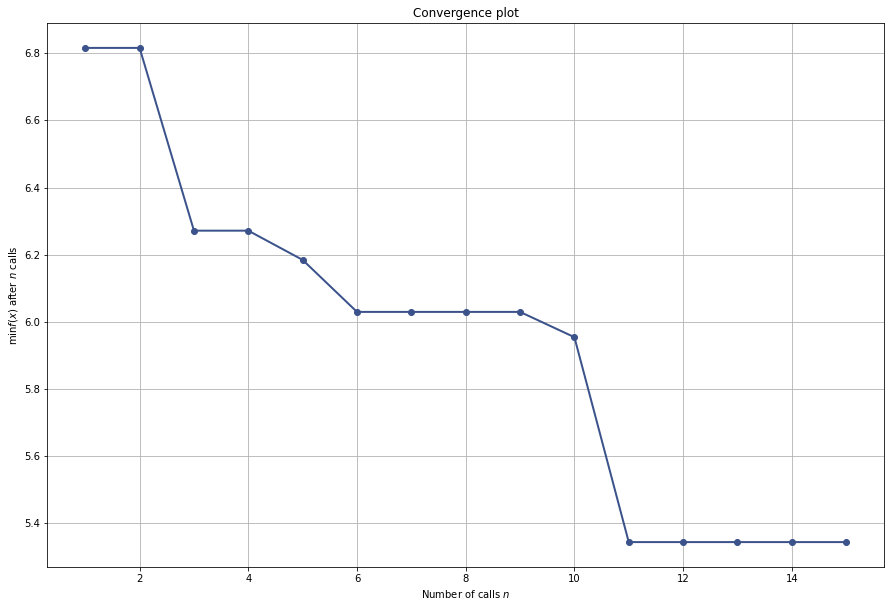

In [22]:
plt.figure(figsize=(15, 10))
plot_convergence(res_gp, );

We have scrachted just the surface here. *Scikit-optimize* is a powerful tool, not limited only in hyperparameter optimization, and as I said my plans are to make a more in-depth review of it in a future post. So stay tunned.

# Item recommendation

Now that we have defined our parameters, we can make our system do what it is suposed to: recommend items. There are many ways to acomplish this, but I optioned to go for the simple way and just recommend items most similar to a item using a *item-based* system.

Let's make the last modification to our *Recommender* class.

In [23]:
class Recommender:
    def __init__(
        self,
        n_users,
        n_items,
        r_mat,
        k=40,
        kind="user",
        bias_sub=False,
        eps=1e-9
    ):
        self.n_users = n_users
        self.n_items = n_items
        self.kind = kind
        self.iter_m = build_interactions_matrix(r_mat, self.n_users, self.n_items)
        self.sim_m = build_similarity_matrix(self.iter_m, kind=self.kind)
        self.bias_sub = bias_sub
        self.k = k
        self.eps = eps
        self.predictions = self._predict_all()
    
    def _predict_all(self):
        pred = np.empty_like(self.iter_m)
        if self.kind == "user":
            # Computes the new interaction matrix if needed.
            iter_m = self.iter_m
            if self.bias_sub:
                user_bias = self.iter_m.mean(axis=1)[:, np.newaxis]
                iter_m -= user_bias
            # An user has the higher similarity score with itself,
            # so we skip the first element.
            sorted_ids = np.argsort(-self.sim_m)[:, 1:self.k+1]
            for user_id, k_users in enumerate(sorted_ids):
                pred[user_id, :] = self.sim_m[user_id, k_users].dot(iter_m[k_users, :])
                pred[user_id, :] /= np.abs(self.sim_m[user_id, k_users]).sum() + self.eps
            if self.bias_sub:
                pred += user_bias
            
        elif self.kind == "item":
            # Computes the new interaction matrix if needed.
            iter_m = self.iter_m
            if self.bias_sub:
                item_bias = self.iter_m.mean(axis=0)[np.newaxis, :]
                iter_m -= item_bias
            # An item has the higher similarity score with itself,
            # so we skip the first element.
            sorted_ids = np.argsort(-self.sim_m)[:, 1:self.k+1]
            for item_id, k_items in enumerate(sorted_ids):
                pred[:, item_id] = self.sim_m[item_id, k_items].dot(iter_m[:, k_items].T)
                pred[:, item_id] /= np.abs(self.sim_m[item_id, k_items]).sum() + self.eps
            if self.bias_sub:
                pred += item_bias
                
        return pred.clip(0, 5)
    
    def get_top_recomendations(self, item_id, n=6):
        if self.kind == "user":
            # For an user-based system, only similarities between users were computed.
            # This strategy will not be covered in this post, but a solution to this
            # could be of finding the top better rated items of similiar users.
            # I'll leave this exercise to you =]
            pass
        if self.kind == "item":
            sim_row = self.sim_m[item_id - 1, :]
            # once again, we skip the first item for obviouos reasons.
            items_idxs = np.argsort(-sim_row)[1:n+1]
            similarities = sim_row[items_idxs]
            return items_idxs + 1, similarities

We added a method to return the $n$ most similar items to a given item. Now, we just need to buil our model with the parameters found previously.

In [24]:
rs_model = Recommender(
    n_users, 
    n_movies, 
    ratings, # the model will be built on the full dataset now
    k=res_gp.x[0], 
    kind="item", 
    bias_sub=res_gp.x[1]
)
get_mse(rs_model, train_set, test_set)

(3.2419262747936157, 3.2242363750751877)

We'll also define two functions: one that maps a movie title to an id and other that maps a list of movie ids into a list of movie titles.

In [25]:
def title2id(mapper_df, movie_title):
    return mapper_df.loc[mapper_df.movie_title == movie_title, "movie_title"].index.values[0]

def ids2title(mapper_df, ids_list):
    titles = []
    for id in ids_list:
        titles.append(mapper_df.loc[id, "movie_title"])
    return titles

Those functions need a dataframe with the movies ids and titles, that will act as a mapper. So we'll load the **u.item** file from the dataset folder.

In [26]:
# Columns names
movies_mapper_cols = [
    "movie_id", 
    "movie_title", 
    "release_date", 
    "video_release_date", 
    "IMDb_URL", 
    "unknown",
    "Action",
    "Adventure",
    "Animation",
    "Childrens",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film_Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci_Fi",
    "Thriller",
    "War",
    "Western" 
]
movies_mapper = pd.read_csv(
    "ml-100k/u.item",
    sep="|",
    encoding="latin",
    names=movies_mapper_cols,
    usecols=["movie_id", "movie_title"], # we only need these columns
    index_col="movie_id"
)
# Remove movies release years from titles
movies_mapper["movie_title"] = movies_mapper["movie_title"].apply(
    lambda title: re.sub("\(\d{4}\)", "", title).strip()
)
movies_mapper

,movie_title
movie_id,
1,Toy Story
2,GoldenEye
3,Four Rooms
4,Get Shorty
5,Copycat
...,...
1678,Mat' i syn
1679,B. Monkey
1680,Sliding Doors


Now we can make our recommendations.

In [27]:
def print_recommendations(model, mapper, movie_title):
    ids_list, similarities = rs_model.get_top_recomendations(title2id(mapper, movie_title))
    titles = ids2title(movies_mapper, ids_list)
    for title, similarity in zip (titles, similarities):
        print(f"{similarity:.2f} -- {title}")

In [28]:
print_recommendations(rs_model, movies_mapper, "Toy Story")

0.73 -- Star Wars
0.70 -- Return of the Jedi
0.69 -- Independence Day (ID4)
0.66 -- Rock, The
0.64 -- Mission: Impossible
0.64 -- Willy Wonka and the Chocolate Factory


In [30]:
print_recommendations(rs_model, movies_mapper, "Batman Returns")

0.71 -- Batman
0.64 -- Batman Forever
0.62 -- Stargate
0.62 -- Die Hard: With a Vengeance
0.61 -- True Lies
0.61 -- Crow, The


In [31]:
print_recommendations(rs_model, movies_mapper, "GoldenEye")

0.66 -- Under Siege
0.62 -- Top Gun
0.62 -- True Lies
0.62 -- Batman
0.60 -- Stargate
0.60 -- Cliffhanger


In [32]:
print_recommendations(rs_model, movies_mapper, "Godfather, The")

0.70 -- Star Wars
0.67 -- Godfather: Part II, The
0.65 -- Fargo
0.63 -- Return of the Jedi
0.59 -- Raiders of the Lost Ark
0.58 -- Pulp Fiction


In [33]:
print_recommendations(rs_model, movies_mapper, "Billy Madison")

0.50 -- Dumb & Dumber
0.49 -- Ace Ventura: Pet Detective
0.45 -- Hot Shots! Part Deux
0.44 -- Brady Bunch Movie, The
0.44 -- Young Guns II
0.43 -- Tommy Boy


In [34]:
print_recommendations(rs_model, movies_mapper, "Lion King, The")

0.75 -- Aladdin
0.69 -- Beauty and the Beast
0.68 -- Forrest Gump
0.66 -- Jurassic Park
0.65 -- E.T. the Extra-Terrestrial
0.65 -- Empire Strikes Back, The


In [35]:
print_recommendations(rs_model, movies_mapper, "Star Wars")

0.88 -- Return of the Jedi
0.76 -- Raiders of the Lost Ark
0.75 -- Empire Strikes Back, The
0.73 -- Toy Story
0.70 -- Godfather, The
0.69 -- Independence Day (ID4)


# Conclusion

What can we say about those recommendations?

Some recommendations are pretty good. For example, "Batman Returns" is similar to other Batman movies, that's for sure. "The Lion King" is similar to "Aladdin" and "Beauty and the Beast" (Disney movies). "Star Wars" is similar to other Star Wars movies.

Some of them does not make much sense. "Toy Story" does not seems so similar to "The Rock" and "Mission: Impossible" to me. "The Lion King" is not so similar to "Jurassic Park" too, aside that both have animals as their main feature. And I certainly cannot understand the similarity between "The Godfather" movies with "Star Wars" movies.

Personal conclusions aside, there are some well-known advantages of memory-based Collaborative Filtering systems in literature. Some of them are:

* **Explainability of the results:** which is an important aspect of recommendations systems;
* **Easy of creation and use:** all methodology is purely based in manipulations of the interactions matrix;
* **Content-independence of the items being recommended:** no descriptions, nor genre definitions, nor color definitions, nor size definition, etc. No metadata at all.

But nothing in this world is perfect, and this approach suffers from disadvantages too. Some of them are:

* **Performance decreases when data gets more sparse:** which occurs frequently with web-related items;
* **Adding new items becomes more complicated:** since the data sctructures representations as an interactions matrix relies on a specific *vector space*, adding new items requires inclusion of the new item and the re-insertion of all elements in the structure.
* **Recommendations tend to be already popular:** items from the so-called [long-tail](https://en.wikipedia.org/wiki/Long_tail) section might get ignored.

The notebook of this post can found [here](https://github.com/TheCamilovisk/DSNotebooks/blob/main/RecommenderSystems/CollaborativeFiltering.ipynb).

A great thanks to [Ethan Rosenthal](https://www.ethanrosenthal.com/#), the author of the [blog post](https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/) which of the ideas and concepts presented here were based on.

Other usefull links:
* [Wikipedia's article on Collaborative Filtering.](https://realpython.com/build-recommendation-engine-collaborative-filtering/#model-based)
* [Real Python post on Collaborative Filtering.](https://realpython.com/build-recommendation-engine-collaborative-filtering/#model-based)
* [Data Flair Recommendations System Project in R.](https://data-flair.training/blogs/data-science-r-movie-recommendation/)
* [Scikit-optimize page.](https://scikit-optimize.github.io/stable/)

Books of interest:
* [Mining of Massive Datasets](https://www.amazon.com.br/dp/1107077230/?tag=n) by Jure Leskovec, Anand Rajaraman, Jeff Ullman
* [Programming Collective Intelligence](https://www.amazon.com.br/dp/0596529325/?tag=n) by Toby Segaran

Thanks for reading to the end, and stay tuned for new posts.